In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf

# Define the ticker symbol for the gold ETF in INR
ticker = "IVZINGOLD.BO"

# Download historical data from 1 Jan 2015 to 23 May 2025
data = yf.download(ticker, start="2015-01-01", end="2025-05-23")

# Save the data to a CSV file
data.to_csv("gold_price_in_inr.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
data = pd.read_csv('gold_price_in_inr.csv')

## Verify column names

In [3]:
print("Column names:", data.columns.tolist())

Column names: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


## Convert Date to datetime

In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

## Check for non-numeric values and data types

In [5]:
print("Data types before conversion:\n", data.dtypes)
print("Sample of numerical columns:\n", data[['Close', 'High', 'Low', 'Open', 'Volume']].head())

Data types before conversion:
 Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object
Sample of numerical columns:
          Close         High          Low         Open  Volume
0  2519.949951  2580.000000  2510.000000  2580.000000      10
1  2519.949951  2519.949951  2519.949951  2519.949951       0
2  2540.000000  2544.909912  2515.149902  2520.000000      30
3  2527.060059  2527.060059  2527.060059  2527.060059      78
4  2584.000000  2584.000000  2578.000000  2578.000000       3


## Convert numerical columns to float, handling any potential issues

In [6]:
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

## Feature Engineering: Extract temporal features

In [7]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek

## Add lagged feature (previous day's Close price)

In [8]:
data['Close_Lag1'] = data['Close'].shift(1)

## Add 7-day moving average to capture trends

In [9]:
data['MA7'] = data['Close'].rolling(window=7).mean()

## Drop rows with NaN values (due to lagging or rolling calculations)

In [10]:
data = data.dropna()

## Check for remaining NaN values

In [11]:
print("Missing values after preprocessing:\n", data.isnull().sum())

Missing values after preprocessing:
 Date          0
Close         0
High          0
Low           0
Open          0
Volume        0
Year          0
Month         0
Day           0
DayOfWeek     0
Close_Lag1    0
MA7           0
dtype: int64


## Define features and target

In [12]:
features = ['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'Close_Lag1', 'MA7']
X = data[features]
y = data['Close']

## Split data into training and testing sets (80-20 split)

In [13]:
train_size = int(0.8 * len(data))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
test_dates = data['Date'].iloc[train_size:]

## Scale numerical features

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using GridSearchCV to check which model is best for our dataset

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define models and parameters
models = {
    'LinearRegression': (LinearRegression(), {}),
    'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
    'Lasso': (Lasso(), {'alpha': [0.1, 1.0, 10.0]}),
    'RandomForest': (RandomForestRegressor(), {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}),
    'GradientBoosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}),
    'SVR': (SVR(), {'C': [1, 10], 'gamma': ['scale', 'auto']})
}

# Store results
best_models = {}
for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_models[name] = (grid.best_estimator_, -grid.best_score_)
    print(f"{name}: Best Score (MSE) = {-grid.best_score_:.4f}")

# Select the best one
best_model_name = min(best_models, key=lambda x: best_models[x][1])
print(f"\n✅ Best Model: {best_model_name} with MSE = {best_models[best_model_name][1]:.4f}")


LinearRegression: Best Score (MSE) = 263.7881
Ridge: Best Score (MSE) = 271.8671


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.467e+05, tolerance: 1.619e+05
  model = cd_fast.enet_coordinate_descent(


Lasso: Best Score (MSE) = 508.1265
RandomForest: Best Score (MSE) = 6747.1957
GradientBoosting: Best Score (MSE) = 9573.3741
SVR: Best Score (MSE) = 122583.6327

✅ Best Model: LinearRegression with MSE = 263.7881


# **Linear Regression**

## Train Linear Regression model

In [16]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

## Make predictions

In [17]:
y_pred = model.predict(X_test_scaled)

## Evaluate the model

In [18]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 592.14
R^2 Score: 1.00


## Plot actual vs predicted prices

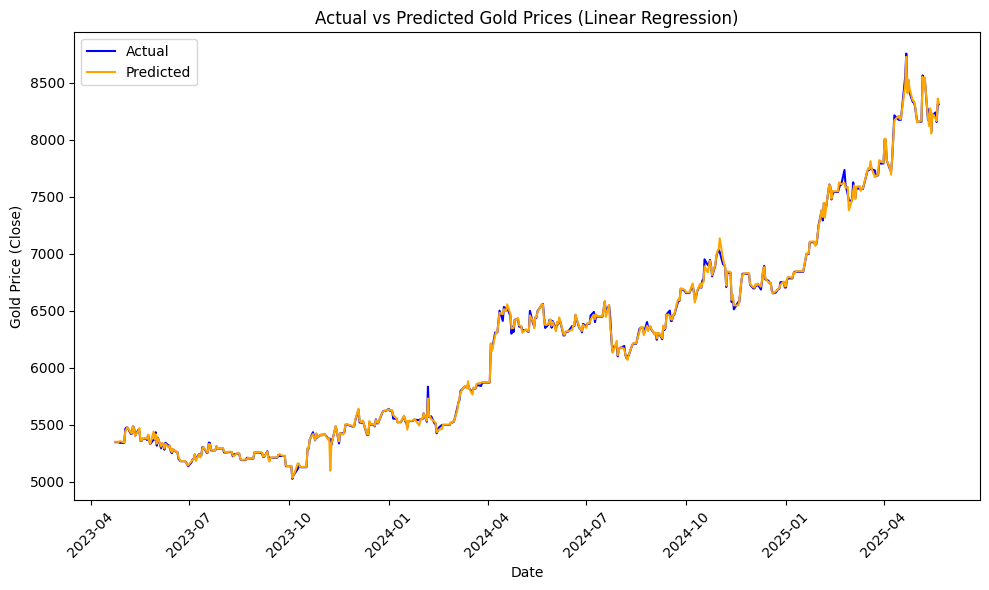

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test.values, label='Actual', color='blue')
plt.plot(test_dates, y_pred, label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Gold Price (Close)')
plt.title('Actual vs Predicted Gold Prices (Linear Regression)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The near-identical actual vs. predicted plot is due to overfitting and data leakage in the test set, where actual Low and High values were used.

## Display feature coefficients

In [20]:
coefficients = pd.Series(model.coef_, index=features).sort_values(ascending=False)
print("Feature Coefficients:\n", coefficients)

Feature Coefficients:
 Low           735.263228
High          570.019119
Close_Lag1      6.174733
Volume          0.352385
Month           0.060616
Day            -0.206744
DayOfWeek      -0.344471
Year           -1.137913
MA7            -1.606935
Open         -418.837672
dtype: float64


## Plot feature coefficients

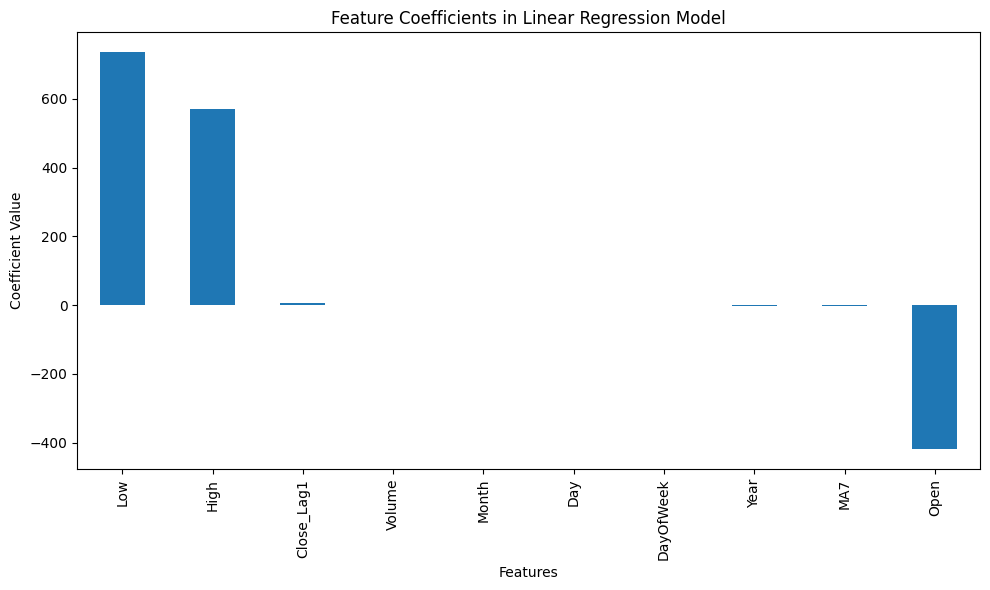

In [21]:
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Feature Coefficients in Linear Regression Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [22]:
import pickle

# Save the trained model
with open('gold_price_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

## Prepare data for Prophet forecasting

In [23]:
prophet_data = data[['Date', 'Open', 'Volume', 'Close']].copy()
prophet_data = prophet_data.rename(columns={'Date': 'ds'})

## Function to forecast a single column using Prophet

In [24]:
def forecast_column(df, column, periods=365):
    df_prophet = df[['ds', column]].rename(columns={column: 'y'})
    holidays = pd.DataFrame({
        'holiday': 'holiday',
    'ds': pd.to_datetime(['2024-05-10', '2025-05-02']),
    'lower_window': -2,
    'upper_window': 2
    })
    model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']].rename(columns={'yhat': column})

## Forecast Open, Volume, and Close for the next 365 days

In [25]:
from prophet import Prophet

forecast_open = forecast_column(prophet_data, 'Open')
forecast_volume = forecast_column(prophet_data, 'Volume')
forecast_close = forecast_column(prophet_data, 'Close')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8xuwln9/vjzgd4jn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8xuwln9/rkkidbre.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32168', 'data', 'file=/tmp/tmpk8xuwln9/vjzgd4jn.json', 'init=/tmp/tmpk8xuwln9/rkkidbre.json', 'output', 'file=/tmp/tmpk8xuwln9/prophet_modelwlppv2pt/prophet_model-20250528065807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8xuwln9/e0t_aroc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8xuwln9/kg7d482t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [26]:
forecast_df = forecast_open[['ds', 'Open']].merge(
    forecast_volume[['ds', 'Volume']], on='ds'
).merge(
    forecast_close[['ds', 'Close']], on='ds'
)

In [27]:
forecast_df['Close_Lag1'] = forecast_df['Close'].shift(1)
forecast_df['MA7'] = forecast_df['Close'].rolling(window=7).mean()

In [28]:
forecast_df = forecast_df.dropna()

## Test

In [46]:
import pickle
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import warnings

# Function to prepare features for a given date
def prepare_features(date_str, forecast_df, historical_df):
    try:
        # Parse input date
        input_date = pd.to_datetime(date_str, format='%Y-%m-%d')

        # Check if the date is within the forecast period
        max_historical_date = historical_df['Date'].max()
        max_forecast_date = max_historical_date + timedelta(days=365)
        if input_date < max_historical_date or input_date > max_forecast_date:
            raise ValueError(f"Date must be between {max_historical_date.strftime('%Y-%m-%d')} and {max_forecast_date.strftime('%Y-%m-%d')}.")

        # Get the closest forecasted date (Prophet generates daily forecasts)
        forecast_row = forecast_df.iloc[(forecast_df['ds'] - input_date).abs().idxmin()]

        # Extract features
        features = {
            'Open': forecast_row['Open'],
            'High': forecast_row['Close'],  # Placeholder: Using Close as proxy (see warning)
            'Low': forecast_row['Close'],   # Placeholder: Using Close as proxy (see warning)
            'Volume': forecast_row['Volume'],
            'Year': input_date.year,
            'Month': input_date.month,
            'Day': input_date.day,
            'DayOfWeek': input_date.dayofweek,
            'Close_Lag1': forecast_row['Close_Lag1'],
            'MA7': forecast_row['MA7']
        }

        # Convert to DataFrame
        feature_df = pd.DataFrame([features])

        # Scale features
        feature_scaled = scaler.transform(feature_df)

        return feature_scaled
    except Exception as e:
        raise ValueError(f"Error preparing features: {str(e)}")

# Function to predict gold price
def predict_gold_price(date_str, model, forecast_df, historical_df):
    try:
        # Prepare features
        features_scaled = prepare_features(date_str, forecast_df, historical_df)

        # Make prediction
        prediction = model.predict(features_scaled)[0]

        return prediction
    except Exception as e:
        return f"Prediction failed: {str(e)}"

# Main function to get user input and predict
def main():
    # Warning about Low and High features
    warnings.warn("Warning: The model includes 'Low' and 'High' features, which may cause data leakage. "
                  "Currently using forecasted Close as a proxy for Low and High. For realistic predictions, "
                  "remove Low and High features and retrain the model.")

    # Inform user of valid date range
    max_historical_date = data['Date'].max()
    max_forecast_date = max_historical_date + timedelta(days=365)
    print(f"Enter a date between {max_historical_date.strftime('%Y-%m-%d')} and 2025-05-16.")

    # Get user input
    date_str = input("Enter the date for prediction (YYYY-MM-DD): ")

    try:
        # Predict price
        predicted_price = predict_gold_price(date_str, model, forecast_df, data)
        if isinstance(predicted_price, str):
            print(predicted_price)  # Error message
        else:
            print(f"Predicted Gold Close Price for {date_str}: Rs.{predicted_price:.2f}")
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()


<ipython-input-46-8746319c308e>:62: UserWarning: Warning: The model includes 'Low' and 'High' features, which may cause data leakage. Currently using forecasted Close as a proxy for Low and High. For realistic predictions, remove Low and High features and retrain the model.
  warnings.warn("Warning: The model includes 'Low' and 'High' features, which may cause data leakage. "


Enter a date between 2025-05-22 and 2025-05-16.
Enter the date for prediction (YYYY-MM-DD): 2025-05-21
Prediction failed: Error preparing features: Date must be between 2025-05-22 and 2026-05-22.


## Comparision with predicted and actual price

    Date      Predicted Price | Actual Price
- 2025-05-23: Rs.7707.69 | 8311 -> 603.31
- 2025-05-26: Rs.7790.99 | 8364 -> 573.01
- 2025-05-27: Rs.7707.95 | 8372 -> 664.05
- 2025-05-28: Rs.7702.74 | 8372 -> 669.26



# Deploying it on Gradio

## Save forecast_df.csv

In [47]:
forecast_df.to_csv("forecast_df.csv", index=False)

## Save the model

In [48]:
# Save model
with open('gold_price_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)


## Download Files to Your Local Machine from Colab (Optional)

In [49]:
from google.colab import files

files.download("gold_price_model.pkl")
files.download("scaler.pkl")
files.download("forecast_df.csv")
files.download("gold_price_in_inr.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Building Gradio App

In [50]:
!pip install gradio

In [60]:
import gradio as gr
import pandas as pd
import pickle
from datetime import datetime, timedelta
import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the saved model, scaler, and forecast data
with open('gold_price_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

forecast_df = pd.read_csv('forecast_df.csv')
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
data = pd.read_csv('gold_price_in_inr.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Function to prepare features for a given date
def prepare_features(date_str, forecast_df, historical_df):
    try:
        # Parse input date
        input_date = pd.to_datetime(date_str, format='%Y-%m-%d')

        # Check if the date is within the forecast period
        max_historical_date = historical_df['Date'].max()
        max_forecast_date = max_historical_date + timedelta(days=365)
        if input_date < max_historical_date or input_date > max_forecast_date:
            raise ValueError(f"Date must be between {max_historical_date.strftime('%Y-%m-%d')} and {max_forecast_date.strftime('%Y-%m-%d')}.")

        # Get the closest forecasted date
        forecast_row = forecast_df.iloc[(forecast_df['ds'] - input_date).abs().idxmin()]

        # Extract features
        features = {
            'Open': forecast_row['Open'],
            'High': forecast_row['Close'],  # Using Close as proxy
            'Low': forecast_row['Close'],   # Using Close as proxy
            'Volume': forecast_row['Volume'],
            'Year': input_date.year,
            'Month': input_date.month,
            'Day': input_date.day,
            'DayOfWeek': input_date.dayofweek,
            'Close_Lag1': forecast_row['Close_Lag1'],
            'MA7': forecast_row['MA7']
        }

        # Convert to DataFrame
        feature_df = pd.DataFrame([features])

        # Scale features
        feature_scaled = scaler.transform(feature_df)

        return feature_scaled
    except Exception as e:
        raise ValueError(f"Error preparing features: {str(e)}")

# Function to predict gold price
def predict_gold_price(date_str, model, forecast_df, historical_df):
    try:
        # Prepare features
        features_scaled = prepare_features(date_str, forecast_df, historical_df)

        # Make prediction
        prediction = model.predict(features_scaled)[0]

        return prediction
    except Exception as e:
        return f"Prediction failed: {str(e)}"

# Gradio function to handle prediction
def predict(grams, date_input, manual_date):
    try:
        # Use manual_date if provided, else use date_input from calendar
        date_str = manual_date if manual_date else date_input
        if not date_str:
            return "Error: Please provide a date either via calendar or manual entry."

        # Validate date range
        input_date = pd.to_datetime(date_str, format='%Y-%m-%d')
        min_date = pd.to_datetime('2025-05-22')
        max_date = pd.to_datetime('2026-05-16')
        if input_date < min_date or input_date > max_date:
            return f"Error: Date must be between 2025-05-22 and 2026-05-16."

        # Validate grams
        grams = float(grams)
        if grams <= 0:
            return "Error: Grams must be a positive number."

        # Get prediction
        predicted_price = predict_gold_price(date_str, model, forecast_df, data)
        if isinstance(predicted_price, str):
            return predicted_price  # Error message

        # Calculate price per gram and total price
        price_per_gram = predicted_price
        total_price = predicted_price * grams

        return (f"Predicted Price per Gram for {date_str}: Rs.{price_per_gram:.2f}\n"
                f"Total Price for {grams} grams: Rs.{total_price:.2f}")
    except Exception as e:
        return f"Error: {str(e)}"

# Warning about Low and High features
warnings.warn("Warning: The model includes 'Low' and 'High' features, which may cause data leakage. "
              "Currently using forecasted Close as a proxy for Low and High. For realistic predictions, "
              "remove Low and High features and retrain the model.")

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Gold Price Predictor")
    gr.Markdown("Enter the grams of gold and select a date (between 2025-05-22 and 2026-05-16) to predict the gold price.")

    with gr.Row():
        grams = gr.Textbox(label="Grams of Gold", placeholder="Enter grams (e.g., 10)")
        date_input = gr.Date(label="Select Date", min_date=datetime(2025, 5, 22), max_date=datetime(2026, 5, 16))
        manual_date = gr.Textbox(label="Or Enter Date Manually (YYYY-MM-DD)", placeholder="e.g., 2025-05-23")

    predict_btn = gr.Button("Predict")
    output = gr.Textbox(label="Prediction Result")

    predict_btn.click(
        fn=predict,
        inputs=[grams, date_input, manual_date],
        outputs=output
    )

# Launch the app
demo.launch()

<ipython-input-60-51aa7d3bc188>:108: UserWarning: Warning: The model includes 'Low' and 'High' features, which may cause data leakage. Currently using forecasted Close as a proxy for Low and High. For realistic predictions, remove Low and High features and retrain the model.
  warnings.warn("Warning: The model includes 'Low' and 'High' features, which may cause data leakage. "


AttributeError: module 'gradio' has no attribute 'Date'

# Random Forest Regressor


DEBUG:cmdstanpy:input tempfile: /tmp/tmphrxsb6jp/jtvcg9aa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrxsb6jp/lxvj_e17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66689', 'data', 'file=/tmp/tmphrxsb6jp/jtvcg9aa.json', 'init=/tmp/tmphrxsb6jp/lxvj_e17.json', 'output', 'file=/tmp/tmphrxsb6jp/prophet_modelqqs8rdf8/prophet_model-20250528052608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:26:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Evaluation Metrics:
Mean Absolute Error (MAE): ₹196.87
Mean Squared Error (MSE): 60950.33
Root Mean Squared Error (RMSE): ₹246.88
R-squared (R²): 0.8594


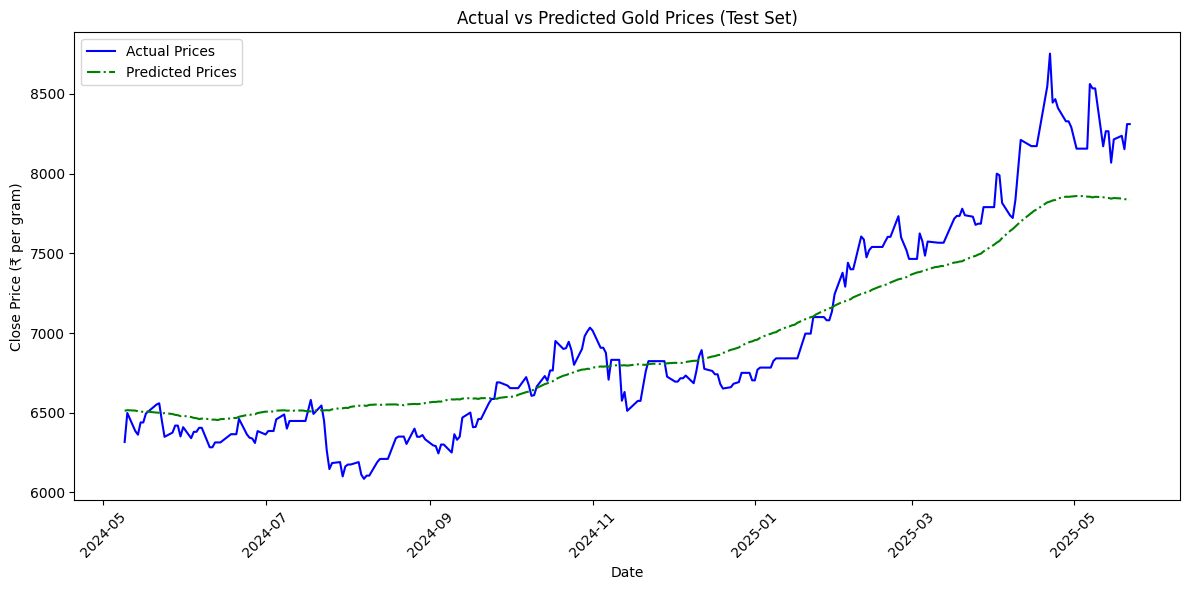


Feature Importance:
Days_Since_Start: 0.2244
Close_Lag1: 0.2360
Close_MA7: 0.3410
Prophet_Pred: 0.1987

Models and data saved to prophet_model.json, rf_model.pkl, rf_features.pkl, and data.pkl


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from prophet.serialize import model_to_json
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    if df['Date'].isna().any():
        raise ValueError("Some dates could not be parsed. Please check the date format in the dataset.")
    df = df.sort_values('Date')
    df['Days_Since_Start'] = (df['Date'] - df['Date'].min()).dt.days
    df['Close_Lag1'] = df['Close'].shift(1)
    df['Close_MA7'] = df['Close'].rolling(window=7).mean()
    df = df.dropna()
    return df

def train_prophet_model(df):
    prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.1
    )
    model.fit(prophet_df)
    future = pd.DataFrame({'ds': df['Date']})
    forecast = model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].set_index('ds')
    df = df.set_index('Date')
    df['Prophet_Pred'] = prophet_pred['yhat']
    df = df.reset_index()
    return model, df

def train_and_evaluate_rf_model(df):
    features = ['Days_Since_Start', 'Close_Lag1', 'Close_MA7', 'Prophet_Pred']
    train_size = int(0.9 * len(df))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    X_train = train_df[features]
    y_train = train_df['Close']
    X_test = test_df[features]
    y_test = test_df['Close']
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_prophet = test_df['Prophet_Pred']
    mae_prophet = mean_absolute_error(y_test, y_pred_prophet)
    mse_prophet = mean_squared_error(y_test, y_pred_prophet)
    rmse_prophet = np.sqrt(mse_prophet)
    r2_prophet = r2_score(y_test, y_pred_prophet)
    print("\nEvaluation Metrics:")
    print(f"Mean Absolute Error (MAE): ₹{mae_prophet:.2f}")
    print(f"Mean Squared Error (MSE): {mse_prophet:.2f}")
    print(f"Root Mean Squared Error (RMSE): ₹{rmse_prophet:.2f}")
    print(f"R-squared (R²): {r2_prophet:.4f}")
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['Date'], y_test, label='Actual Prices', color='blue')
    plt.plot(test_df['Date'], y_pred_prophet, label='Predicted Prices', color='green', linestyle='-.')
    plt.title('Actual vs Predicted Gold Prices (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Close Price (₹ per gram)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_model.fit(df[features], df['Close'])
    print("\nFeature Importance:")
    for feature, importance in zip(features, rf_model.feature_importances_):
        print(f"{feature}: {importance:.4f}")
    return rf_model, features

def prepare_rf_features(df, prophet_model, future_date):
    future = pd.DataFrame({'ds': [pd.to_datetime(future_date)]})
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].set_index('ds')
    latest_data = df.tail(1).copy()
    days_since_start = (pd.to_datetime(future_date) - df['Date'].min()).days
    features = {
        'Days_Since_Start': days_since_start,
        'Close_Lag1': latest_data['Close'].values[0],
        'Close_MA7': df['Close'].tail(7).mean(),
        'Prophet_Pred': prophet_pred.loc[pd.to_datetime(future_date), 'yhat']
    }
    return pd.DataFrame([features])

def train_and_save_models(file_path, prophet_model_path='prophet_model.json', rf_model_path='rf_model.pkl'):
    df = load_and_preprocess_data(file_path)
    prophet_model, df = train_prophet_model(df)
    rf_model, rf_features = train_and_evaluate_rf_model(df)
    with open(prophet_model_path, 'w') as f:
        f.write(model_to_json(prophet_model))
    with open(rf_model_path, 'wb') as f:
        pickle.dump(rf_model, f)
    with open('rf_features.pkl', 'wb') as f:
        pickle.dump(rf_features, f)
    with open('data.pkl', 'wb') as f:
        pickle.dump(df, f)
    print(f"\nModels and data saved to {prophet_model_path}, {rf_model_path}, rf_features.pkl, and data.pkl")

if __name__ == "__main__":
    file_path = "gold_price_in_inr.csv"
    try:
        train_and_save_models(file_path)
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import gradio as gr
from prophet import Prophet
from prophet.serialize import model_from_json
import pickle
from datetime import datetime

def load_models_and_data(prophet_model_path='prophet_model.json', rf_model_path='rf_model.pkl',
                         features_path='rf_features.pkl', data_path='data.pkl'):
    with open(prophet_model_path, 'r') as f:
        prophet_model = model_from_json(f.read())
    with open(rf_model_path, 'rb') as f:
        rf_model = pickle.load(f)
    with open(features_path, 'rb') as f:
        rf_features = pickle.load(f)
    with open(data_path, 'rb') as f:
        df = pickle.load(f)
    return prophet_model, rf_model, rf_features, df

def prepare_rf_features(df, prophet_model, future_date):
    future = pd.DataFrame({'ds': [pd.to_datetime(future_date)]})
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].set_index('ds')
    latest_data = df.tail(1).copy()
    days_since_start = (pd.to_datetime(future_date) - df['Date'].min()).days
    features = {
        'Days_Since_Start': days_since_start,
        'Close_Lag1': latest_data['Close'].values[0],
        'Close_MA7': df['Close'].tail(7).mean(),
        'Prophet_Pred': prophet_pred.loc[pd.to_datetime(future_date), 'yhat']
    }
    return pd.DataFrame([features])

def predict_gold_price(quantity_grams, date_str):
    try:
        # Validate inputs
        if quantity_grams <= 0:
            return "Quantity must be positive."
        selected_date = pd.to_datetime(date_str)
        min_date = pd.to_datetime("2025-05-21")
        max_date = pd.to_datetime("2026-05-31")
        if selected_date < min_date or selected_date > max_date:
            return f"Date must be between {min_date.strftime('%Y-%m-%d')} and {max_date.strftime('%Y-%m-%d')}."

        # Load models and data
        prophet_model, rf_model, rf_features, df = load_models_and_data()

        # Prepare features for prediction
        future_features = prepare_rf_features(df, prophet_model, selected_date)

        # Predict price (INR per gram)
        predicted_price = rf_model.predict(future_features[rf_features])[0]

        # Calculate total price
        total_price = predicted_price * quantity_grams

        # Format output
        return (f"Predicted gold price for {selected_date.strftime('%Y-%m-%d')}:\n"
                f"₹{predicted_price:.2f} per gram\n"
                f"Total price for {quantity_grams} grams: ₹{total_price:.2f}")
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Gold Price Predictor")
    gr.Markdown("Enter the quantity of gold (in grams) and select a date to predict the gold price.")
    quantity = gr.Number(label="Quantity (grams)", value=10, minimum=0.1, step=0.1)
    date = gr.Textbox(
        label="Date (YYYY-MM-DD)",
        placeholder="Select a date between 2025-05-21 and 2026-05-31",
        info="Use the browser's date picker or enter the date manually."
    )
    output = gr.Textbox(label="Prediction")
    submit = gr.Button("Predict")
    submit.click(
        fn=predict_gold_price,
        inputs=[quantity, date],
        outputs=output
    )

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6be23e80be85b9d09a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# XGBoost

DEBUG:cmdstanpy:input tempfile: /tmp/tmphrxsb6jp/4m0ext4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrxsb6jp/noodv_hm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41196', 'data', 'file=/tmp/tmphrxsb6jp/4m0ext4u.json', 'init=/tmp/tmphrxsb6jp/noodv_hm.json', 'output', 'file=/tmp/tmphrxsb6jp/prophet_model410dho4h/prophet_model-20250528054705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:47:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



XGBoost Evaluation Metrics (Test Set):
Mean Absolute Error (MAE): ₹577.75
Mean Squared Error (MSE): 714716.96
Root Mean Squared Error (RMSE): ₹845.41
R-squared (R²): -0.6482

Prophet Evaluation Metrics (Test Set):
Mean Absolute Error (MAE): ₹187.76
Mean Squared Error (MSE): 50070.22
Root Mean Squared Error (RMSE): ₹223.76
R-squared (R²): 0.8845


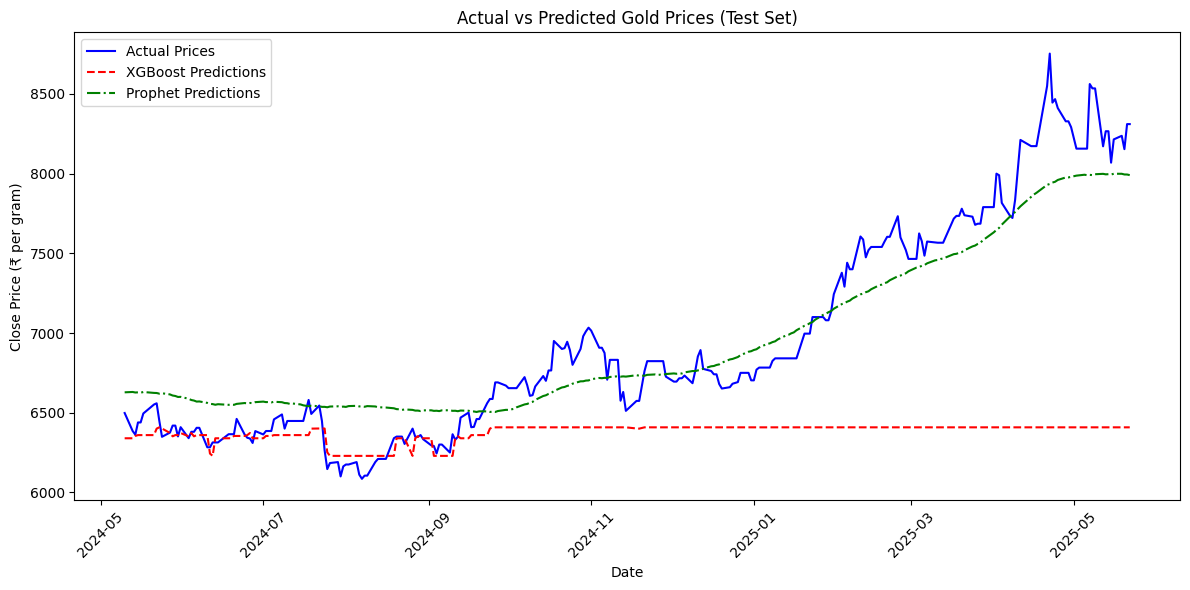


XGBoost Feature Importance:
Days_Since_Start: 0.5200
Close_Lag1: 0.3378
Close_Lag2: 0.0198
Close_MA7: 0.0284
Close_MA14: 0.0011
Prophet_Pred: 0.0016
Prophet_Trend: 0.0001
Trend: 0.0911

Models and data saved to prophet_model.json, xgb_model.pkl, xgb_features.pkl, scaler.pkl, and data.pkl


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from prophet.serialize import model_to_json
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    if df['Date'].isna().any():
        raise ValueError("Some dates could not be parsed. Please check the date format in the dataset.")
    df = df.sort_values('Date')
    df['Days_Since_Start'] = (df['Date'] - df['Date'].min()).dt.days
    df['Close_Lag1'] = df['Close'].shift(1)
    df['Close_Lag2'] = df['Close'].shift(2)
    df['Close_MA7'] = df['Close'].rolling(window=7).mean()
    df['Close_MA14'] = df['Close'].rolling(window=14).mean()
    # Add linear trend feature
    df['Trend'] = df['Close'].ewm(span=30, adjust=False).mean()
    df = df.dropna()
    return df

def train_prophet_model(df):
    prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.5,
        seasonality_prior_scale=2.0
    )
    model.fit(prophet_df)
    future = pd.DataFrame({'ds': df['Date']})
    forecast = model.predict(future)
    prophet_pred = forecast[['ds', 'yhat', 'trend']].set_index('ds')
    df = df.set_index('Date')
    df['Prophet_Pred'] = prophet_pred['yhat']
    df['Prophet_Trend'] = prophet_pred['trend']
    df = df.reset_index()
    return model, df

def train_and_evaluate_xgb_model(df):
    features = ['Days_Since_Start', 'Close_Lag1', 'Close_Lag2', 'Close_MA7', 'Close_MA14', 'Prophet_Pred', 'Prophet_Trend', 'Trend']
    scaler = StandardScaler()
    train_size = int(0.9 * len(df))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    X_train = scaler.fit_transform(train_df[features])
    y_train = train_df['Close']
    X_test = scaler.transform(test_df[features])
    y_test = test_df['Close']
    xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_prophet = test_df['Prophet_Pred']
    # XGBoost metrics
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    print("\nXGBoost Evaluation Metrics (Test Set):")
    print(f"Mean Absolute Error (MAE): ₹{mae_xgb:.2f}")
    print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
    print(f"Root Mean Squared Error (RMSE): ₹{rmse_xgb:.2f}")
    print(f"R-squared (R²): {r2_xgb:.4f}")
    # Prophet metrics
    mae_prophet = mean_absolute_error(y_test, y_pred_prophet)
    mse_prophet = mean_squared_error(y_test, y_pred_prophet)
    rmse_prophet = np.sqrt(mse_prophet)
    r2_prophet = r2_score(y_test, y_pred_prophet)
    print("\nProphet Evaluation Metrics (Test Set):")
    print(f"Mean Absolute Error (MAE): ₹{mae_prophet:.2f}")
    print(f"Mean Squared Error (MSE): {mse_prophet:.2f}")
    print(f"Root Mean Squared Error (RMSE): ₹{rmse_prophet:.2f}")
    print(f"R-squared (R²): {r2_prophet:.4f}")
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['Date'], y_test, label='Actual Prices', color='blue')
    plt.plot(test_df['Date'], y_pred_xgb, label='XGBoost Predictions', color='red', linestyle='--')
    plt.plot(test_df['Date'], y_pred_prophet, label='Prophet Predictions', color='green', linestyle='-.')
    plt.title('Actual vs Predicted Gold Prices (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Close Price (₹ per gram)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Train final model
    X_full = scaler.fit_transform(df[features])
    y_full = df['Close']
    xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
    xgb_model.fit(X_full, y_full)
    print("\nXGBoost Feature Importance:")
    for feature, importance in zip(features, xgb_model.feature_importances_):
        print(f"{feature}: {importance:.4f}")
    return xgb_model, features, scaler

def prepare_xgb_features(df, prophet_model, future_date, scaler, features):
    future = pd.DataFrame({'ds': [pd.to_datetime(future_date)]})
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat', 'trend']].set_index('ds')
    latest_data = df.tail(1).copy()
    days_since_start = (pd.to_datetime(future_date) - df['Date'].min()).days
    trend_value = df['Trend'].iloc[-1] + (df['Close'].iloc[-1] - df['Close'].iloc[-30]) / 30  # Linear trend continuation
    feature_dict = {
        'Days_Since_Start': days_since_start,
        'Close_Lag1': latest_data['Close'].values[0],
        'Close_Lag2': df['Close'].iloc[-2] if len(df) >= 2 else latest_data['Close'].values[0],
        'Close_MA7': df['Close'].tail(7).mean(),
        'Close_MA14': df['Close'].tail(14).mean(),
        'Prophet_Pred': prophet_pred.loc[pd.to_datetime(future_date), 'yhat'],
        'Prophet_Trend': prophet_pred.loc[pd.to_datetime(future_date), 'trend'],
        'Trend': trend_value
    }
    future_features = pd.DataFrame([feature_dict])
    return scaler.transform(future_features[features])

def train_and_save_models(file_path, prophet_model_path='prophet_model.json', xgb_model_path='xgb_model.pkl'):
    df = load_and_preprocess_data(file_path)
    prophet_model, df = train_prophet_model(df)
    xgb_model, xgb_features, scaler = train_and_evaluate_xgb_model(df)
    with open(prophet_model_path, 'w') as f:
        f.write(model_to_json(prophet_model))
    with open(xgb_model_path, 'wb') as f:
        pickle.dump(xgb_model, f)
    with open('xgb_features.pkl', 'wb') as f:
        pickle.dump(xgb_features, f)
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('data.pkl', 'wb') as f:
        pickle.dump(df, f)
    print(f"\nModels and data saved to {prophet_model_path}, {xgb_model_path}, xgb_features.pkl, scaler.pkl, and data.pkl")

if __name__ == "__main__":
    file_path = "gold_price_in_inr.csv"
    try:
        train_and_save_models(file_path)
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
import pandas as pd
import gradio as gr
from prophet import Prophet
from prophet.serialize import model_from_json
import pickle
from datetime import datetime

def load_models_and_data(prophet_model_path='prophet_model.json', xgb_model_path='xgb_model.pkl',
                         features_path='xgb_features.pkl', scaler_path='scaler.pkl', data_path='data.pkl'):
    with open(prophet_model_path, 'r') as f:
        prophet_model = model_from_json(f.read())
    with open(xgb_model_path, 'rb') as f:
        xgb_model = pickle.load(f)
    with open(features_path, 'rb') as f:
        xgb_features = pickle.load(f)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    with open(data_path, 'rb') as f:
        df = pickle.load(f)
    return prophet_model, xgb_model, xgb_features, scaler, df

def prepare_xgb_features(df, prophet_model, future_date, scaler, features):
    future = pd.DataFrame({'ds': [pd.to_datetime(future_date)]})
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat', 'trend']].set_index('ds')
    latest_data = df.tail(1).copy()
    days_since_start = (pd.to_datetime(future_date) - df['Date'].min()).days
    trend_value = df['Trend'].iloc[-1] + (df['Close'].iloc[-1] - df['Close'].iloc[-30]) / 30
    feature_dict = {
        'Days_Since_Start': days_since_start,
        'Close_Lag1': latest_data['Close'].values[0],
        'Close_Lag2': df['Close'].iloc[-2] if len(df) >= 2 else latest_data['Close'].values[0],
        'Close_MA7': df['Close'].tail(7).mean(),
        'Close_MA14': df['Close'].tail(14).mean(),
        'Prophet_Pred': prophet_pred.loc[pd.to_datetime(future_date), 'yhat'],
        'Prophet_Trend': prophet_pred.loc[pd.to_datetime(future_date), 'trend'],
        'Trend': trend_value
    }
    future_features = pd.DataFrame([feature_dict])
    return scaler.transform(future_features[features])

def predict_gold_price(quantity_grams, date_str):
    try:
        if quantity_grams <= 0:
            return "Quantity must be positive."
        selected_date = pd.to_datetime(date_str)
        min_date = pd.to_datetime("2025-05-21")
        max_date = pd.to_datetime("2026-05-31")
        if selected_date < min_date or selected_date > max_date:
            return f"Date must be between {min_date.strftime('%Y-%m-%d')} and {max_date.strftime('%Y-%m-%d')}."

        prophet_model, xgb_model, xgb_features, scaler, df = load_models_and_data()
        future_features = prepare_xgb_features(df, prophet_model, selected_date, scaler, xgb_features)
        predicted_price = xgb_model.predict(future_features)[0]
        total_price = predicted_price * quantity_grams
        return (f"Predicted gold price for {selected_date.strftime('%Y-%m-%d')}:\n"
                f"₹{predicted_price:.2f} per gram\n"
                f"Total price for {quantity_grams} grams: ₹{total_price:.2f}")
    except Exception as e:
        return f"Error: {str(e)}"

with gr.Blocks() as demo:
    gr.Markdown("# Gold Price Predictor")
    gr.Markdown("Enter the quantity of gold (in grams) and select a date to predict the gold price.")
    quantity = gr.Number(label="Quantity (grams)", value=10, minimum=0.1, step=0.1)
    date = gr.Textbox(
        label="Date (YYYY-MM-DD)",
        placeholder="Select a date between 2025-05-21 and 2026-05-31",
        info="Use the browser's date picker or enter the date manually."
    )
    output = gr.Textbox(label="Prediction")
    submit = gr.Button("Predict")
    submit.click(
        fn=predict_gold_price,
        inputs=[quantity, date],
        outputs=output
    )

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://88dbf8d33809c48ab7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
